<a href="https://colab.research.google.com/github/Abhranil2021/T2I2T_Text-To-Image-To-Text/blob/main/TextToImage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text To Image To Text(T2I2T)

The aim of this project is to convert text to image and vice-versa. If a text is given as input, random high-quality and artistic images are displayed as outputs. If an image is given as input, captions are generated as output corresponding to that of the input text.

This is the notebook for the text to image part. In this notebook I have used a pretrained Dall-E Mini Model to generate images from text input. For more details, refer to the poster of the project in the Github repository for this project.

# DALL·E mini - Inference pipeline

*Generate images from a text prompt*

<img src="https://github.com/borisdayma/dalle-mini/blob/main/img/logo.png?raw=true" width="200">

This notebook illustrates [DALL·E mini](https://github.com/borisdayma/dalle-mini) inference pipeline.

Just want to play? Use [the demo](https://huggingface.co/spaces/flax-community/dalle-mini).

For more understanding of the model, refer to [the report](https://wandb.ai/dalle-mini/dalle-mini/reports/DALL-E-mini--Vmlldzo4NjIxODA).

## 🛠️ Installation and set-up

In [ ]:
# Install required libraries
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q git+https://github.com/patil-suraj/vqgan-jax.git
!pip install -q git+https://github.com/borisdayma/dalle-mini.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 6.6 MB 4.4 MB/s 
     |████████████████████████████████| 895 kB 43.1 MB/s 
     |████████████████████████████████| 77 kB 6.2 MB/s 
     |████████████████████████████████| 596 kB 47.6 MB/s 
     |████████████████████████████████| 184 kB 4.3 MB/s 
     |████████████████████████████████| 140 kB 44.7 MB/s 
     |████████████████████████████████| 72 kB 727 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 235 kB 4.3 MB/s 
     |████████████████████████████████| 175 kB 44.0 MB/s 
     |████████████████████████████████| 1.8 MB 40.8 MB/s 
     |████████████████████████████████| 53 kB 1.6 MB/s 
     |████████████████████████████████| 181 kB 47.6 MB/s 
     |████████████████████████████████| 144 kB 50.6 MB/s 
   

We load required models:
* dalle·mini for text to encoded images
* VQGAN for decoding images
* CLIP for scoring predictions

In [ ]:
# Model references

# dalle-mini
DALLE_MODEL = "dalle-mini/dalle-mini/wzoooa1c:latest"  # can be wandb artifact or 🤗 Hub or local folder or google bucket
DALLE_COMMIT_ID = None

# VQGAN model
VQGAN_REPO = "dalle-mini/vqgan_imagenet_f16_16384"
VQGAN_COMMIT_ID = "e93a26e7707683d349bf5d5c41c5b0ef69b677a9"

# CLIP model
CLIP_REPO = "openai/clip-vit-large-patch14"
CLIP_COMMIT_ID = None

In [ ]:
import jax
import jax.numpy as jnp

# check how many devices are available
jax.local_device_count()

1

In [ ]:
# Load models & tokenizer
from dalle_mini import DalleBart, DalleBartProcessor
from vqgan_jax.modeling_flax_vqgan import VQModel
from transformers import CLIPProcessor, FlaxCLIPModel

# Load dalle-mini
model = DalleBart.from_pretrained(
    DALLE_MODEL, revision=DALLE_COMMIT_ID, abstract_init=True
)

# Load VQGAN
vqgan = VQModel.from_pretrained(VQGAN_REPO, revision=VQGAN_COMMIT_ID)

# Load CLIP
clip = FlaxCLIPModel.from_pretrained(CLIP_REPO, revision=CLIP_COMMIT_ID)
clip_processor = CLIPProcessor.from_pretrained(CLIP_REPO, revision=CLIP_COMMIT_ID)

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Downloading large artifact wzoooa1c:latest, 1672.79MB. 7 files... Done. 0:0:0


Downloading:   0%|          | 0.00/434 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/290M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.31k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.59G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/316 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/905 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/939k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/512k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.12M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Model parameters are replicated on each device for faster inference.

In [ ]:
from flax.jax_utils import replicate

model._params = replicate(model.params)
vqgan._params = replicate(vqgan.params)
clip._params = replicate(clip.params)

Model functions are compiled and parallelized to take advantage of multiple devices.

In [ ]:
from functools import partial

# model inference
@partial(jax.pmap, axis_name="batch", static_broadcasted_argnums=(3, 4, 5, 6))
def p_generate(
    tokenized_prompt, key, params, top_k, top_p, temperature, condition_scale
):
    return model.generate(
        **tokenized_prompt,
        prng_key=key,
        params=params,
        top_k=top_k,
        top_p=top_p,
        temperature=temperature,
        condition_scale=condition_scale,
    )


# decode image
@partial(jax.pmap, axis_name="batch")
def p_decode(indices, params):
    return vqgan.decode_code(indices, params=params)


# score images
@partial(jax.pmap, axis_name="batch")
def p_clip(inputs, params):
    logits = clip(params=params, **inputs).logits_per_image
    return logits

Keys are passed to the model on each device to generate unique inference per device.

In [ ]:
import random

# create a random key
seed = random.randint(0, 2**32 - 1)
key = jax.random.PRNGKey(seed)

## 🖍 Text Prompt

Our model requires processing prompts.

In [ ]:
from dalle_mini import DalleBartProcessor

processor = DalleBartProcessor.from_pretrained(DALLE_MODEL, revision=DALLE_COMMIT_ID)

wandb: Downloading large artifact wzoooa1c:latest, 1672.79MB. 7 files... Done. 0:0:0


Downloading:   0%|          | 0.00/33.8M [00:00<?, ?B/s]

Let's define a text prompt.

In [ ]:
prompt = "sunset over a lake in the mountains"

In [ ]:
tokenized_prompt = processor([prompt])

Finally we replicate it onto each device.

In [ ]:
tokenized_prompt = replicate(tokenized_prompt)

## 🎨 Generate images

We generate images using dalle-mini model and decode them with the VQGAN.

In [ ]:
# number of predictions
n_predictions = 16

# We can customize top_k/top_p used for generating samples
gen_top_k = None
gen_top_p = None
temperature = 0.85
cond_scale = 3.0

In [ ]:
from flax.training.common_utils import shard_prng_key
import numpy as np
from PIL import Image
from tqdm.notebook import trange

# generate images
images = []
for i in trange(max(n_predictions // jax.device_count(), 1)):
    # get a new key
    key, subkey = jax.random.split(key)
    # generate images
    encoded_images = p_generate(
        tokenized_prompt,
        shard_prng_key(subkey),
        model.params,
        gen_top_k,
        gen_top_p,
        temperature,
        cond_scale,
    )
    # remove BOS
    encoded_images = encoded_images.sequences[..., 1:]
    # decode images
    decoded_images = p_decode(encoded_images, vqgan.params)
    decoded_images = decoded_images.clip(0.0, 1.0).reshape((-1, 256, 256, 3))
    for img in decoded_images:
        images.append(Image.fromarray(np.asarray(img * 255, dtype=np.uint8)))

  0%|          | 0/16 [00:00<?, ?it/s]

Let's calculate their score with CLIP.

In [ ]:
from flax.training.common_utils import shard

# get clip scores
clip_inputs = clip_processor(
    text=[prompt] * jax.device_count(),
    images=images,
    return_tensors="np",
    padding="max_length",
    max_length=77,
    truncation=True,
).data
logits = p_clip(shard(clip_inputs), clip.params)
logits = logits.squeeze().flatten()

Let's display images ranked by CLIP score.

Prompt: sunset over a lake in the mountains



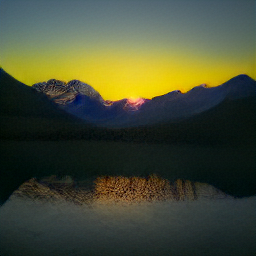

Score: 28.90



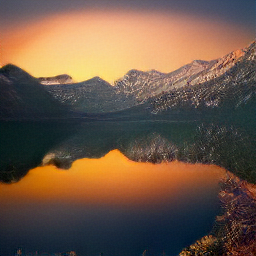

Score: 28.40



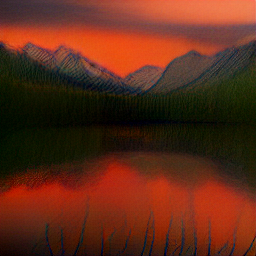

Score: 27.53



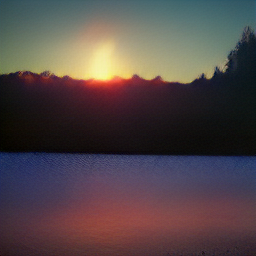

Score: 27.28



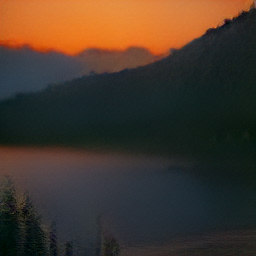

Score: 27.00



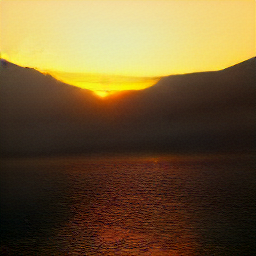

Score: 26.94



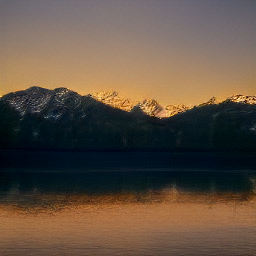

Score: 26.57



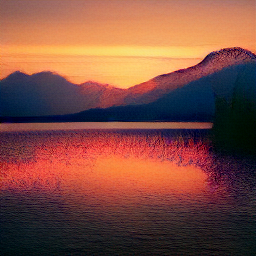

Score: 25.79



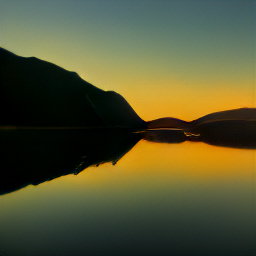

Score: 25.16



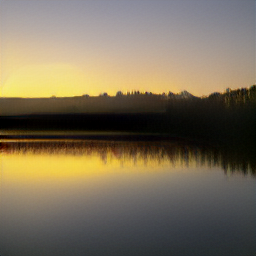

Score: 25.16



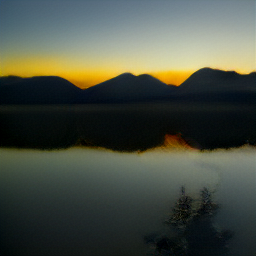

Score: 25.05



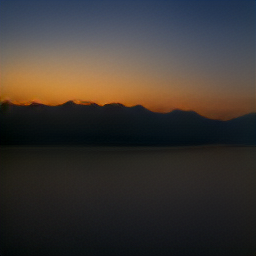

Score: 24.90



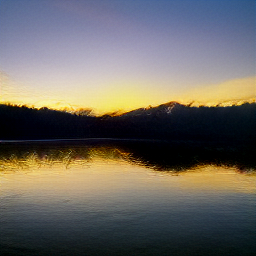

Score: 24.57



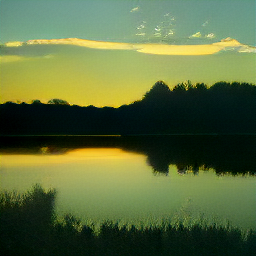

Score: 23.99



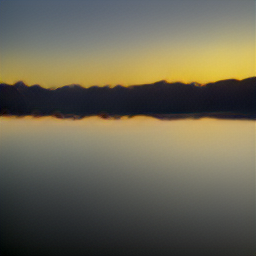

Score: 23.43



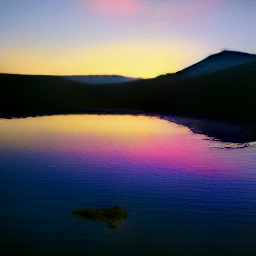

Score: 23.03



In [ ]:
print(f"Prompt: {prompt}\n")
for idx in logits.argsort()[::-1]:
    display(images[idx])
    print(f"Score: {logits[idx]:.2f}\n")

In [ ]:
def wrapping_function(prompt, n_images = 4):
  n_predictions = n_images

  tokenized_prompt = processor([prompt])
  tokenized_prompt = replicate(tokenized_prompt)

  # We can customize top_k/top_p used for generating samples
  gen_top_k = None
  gen_top_p = None
  temperature = 0.85
  cond_scale = 3.0 

  images = []
  for i in trange(n_predictions//jax.local_device_count()):
      # get a new key
      seed = random.randint(0, 2**32 - 1)
      key = jax.random.PRNGKey(seed)
      key, subkey = jax.random.split(key)
      # generate images
      encoded_images = p_generate(
                                  tokenized_prompt,
                                  shard_prng_key(subkey),
                                  model.params,
                                  gen_top_k,
                                  gen_top_p,
                                  temperature,
                                  cond_scale
                                  )
      # remove BOS
      encoded_images = encoded_images.sequences[..., 1:]
      # decode images
      decoded_images = p_decode(encoded_images, vqgan.params)
      decoded_images = decoded_images.clip(0.0, 1.0).reshape((-1, 256, 256, 3))
      for img in decoded_images:
        images.append(Image.fromarray(np.asarray(img * 255, dtype=np.uint8)))

  return images

## Deployment 

We have used **Gradio** as backend in order to deploy the project.

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr

In [ ]:
inputs = [gr.inputs.Textbox(lines = 1, placeholder = "Please enter text", default = "", label = "Input Text")]
          # gr.inputs.Number(default = int, label = "How many images do you want?")]

outputs = gr.outputs.Carousel(['image'], label = "Browse through the carousel to look at the generated images")

app = gr.Interface(fn = wrapping_function, inputs = inputs, outputs = outputs,
                   title = "Text To Image",
                   description = "This is an application which generates high quality and artistic images from a text prompt. So let your imagination run free, and generate images for whatever idea comes to your mind!!",
                   theme = "huggingface")

In [ ]:
app.launch(share = True, debug = True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://22011.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)
